# Can an Algorithm Reliably Detect Robot Bids in an Online Auction?: A Classification Project

Online auction sites have a problem: automated bidders, with frustrating regularity, swoop in at the last minute and  steal auctions from enthusastic human users. Sites desperately want to ban these bots, but automated bidders, on the surface, look just like human users, so how can we tell the difference? To help, I used bidder data from an online aution site to build a model that could reliably distinguish robots from humans. And because I prioritized recall highly -- even if we end up bothering a few humans, let's catch as many pesky robots as possible -- I privileged the F1 score as my go-to success metric. 

In [2]:
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# modelling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

#display options
pd.options.display.float_format = '{:.4f}'.format

# Step One: Read in the Data

I began by reading in my data into separate pandas dataframes. The bidders dataset includes bidder userIDs along with labels that indicate whether that user has been found to be a human or a robot was read into df_bidders. 

The bids dataset includes a list of 7.6 million and corresponding information such as: time, country, merchandise category, device was read into df_bids. Also, for each bid, I then appended the bidders dataset info, to this dataframe.

In [24]:
df_bidders = pd.read_csv("train.csv")
df_bids = pd.read_csv("nyc19_ds21/bids.csv")
df_bids = pd.merge(df_bids, df_bidders, on="bidder_id")

<H1>Step Two: Engineer Features

In order to build a classification model, I needed to engineer useful features, from the raw data in df_bids, that distinguish between humans and robots. I'll tack those features onto df_bidders, which is the dataframe I'll later use for modeling.

In [31]:
#HOW OFTEN DO USERS PLACE SIMULTANEOUS BIDS?

def simultaneous_bids(times):
    return len(set(times))==len(times)

df_simult_bids = pd.DataFrame(df_bids.groupby(["bidder_id"])
                              .apply(lambda x: simultaneous_bids(x["time"]))).reset_index()

df_bidders = pd.merge(df_simult_bids, df_bidders, on="bidder_id")
df_bidders = df_bidders.rename(columns = {0:"simult_bids"})
df_bidders = df_bidders[['bidder_id', 'payment_account', 'address', 'outcome', 'simult_bids']]

In [32]:
#DOES A USER MAKE BIDS FROM MULTIPLE COUNTRIES?

def mult_countries(countries):
    return len(set(countries))==len(countries)

df_mult_countries = pd.DataFrame(df_bids.groupby(["bidder_id"])
                               .apply(lambda x: mult_countries(x["time"]))).reset_index()
df_mult_countries = df_mult_countries.rename(columns ={0:"mult_countries"})
df_bidders = pd.merge(df_mult_countries, df_bidders, on="bidder_id")
df_bidders = df_bidders[['bidder_id', 'payment_account', 'address', 'outcome', 'simult_bids', 'mult_countries']]

In [33]:
#WHICH CATEGORIES DOES A USER BID ON?

df_merch_dummies = pd.get_dummies(df_bids, columns=['merchandise'])
df_merch_dummies = (df_merch_dummies.groupby(["bidder_id"]).agg({
    "merchandise_auto parts": lambda x: sum(x)>0, 
    "merchandise_books and music": lambda x: sum(x)>0, 
    "merchandise_clothing": lambda x: sum(x)>0, 
    "merchandise_computers": lambda x: sum(x)>0,
    "merchandise_furniture": lambda x: sum(x)>0, 
    "merchandise_home goods": lambda x: sum(x)>0, 
    "merchandise_jewelry": lambda x: sum(x)>0, 
    "merchandise_mobile": lambda x: sum(x)>0, 
    "merchandise_office equipment": lambda x: sum(x)>0,
    "merchandise_sporting goods": lambda x: sum(x)>0}).reset_index())
df_bidders = pd.merge(df_bidders, df_merch_dummies, on="bidder_id")

In [34]:
#WHAT'S THE MOST FREQUENT MERCHANDISE CATEGORY A USER BIDS ON?

most_freq_merch = df_bids.groupby(["bidder_id"]).agg({"merchandise": lambda x:x.value_counts().index[0]})
most_freq_merch = most_freq_merch.reset_index()
most_freq_merch_dummies = pd.get_dummies(most_freq_merch, columns=['merchandise'])
df_bidders = pd.merge(df_bidders, most_freq_merch_dummies, on="bidder_id")

In [35]:
#TOTAL BIDS PER USER

user_total_bids = df_bids.groupby("bidder_id").agg({"bid_id":"count"}).reset_index()
user_total_bids = user_total_bids.rename(columns={"bid_id": "user_total_bids"})
df_bidders = pd.merge(df_bidders, user_total_bids, on="bidder_id")

In [36]:
#AVERAGE BIDS PER AUCTION

df_bids_per_auction = df_bids.groupby(["bidder_id","auction"]).agg({"bid_id":"count"}).reset_index()
df_avg_bids_per_auction = df_bids_per_auction.groupby(["bidder_id"]).agg({"bid_id":"mean"}).reset_index()
df_bidders = pd.merge(df_bidders, df_avg_bids_per_auction, on="bidder_id")
df_bidders = df_bidders.rename(columns={"bid_id":"avg_bids_per_auction"})

In [37]:
#TIME SINCE USER'S LAST BID

df_bids["previous_time"] = df_bids.groupby("bidder_id")["time"].apply(lambda grp: grp.shift(1))
df_bids["time_since_previous_bid"] = df_bids["time"] - df_bids["previous_time"]
np.mean(df_bids["time_since_previous_bid"])
df_bids["time_since_previous_bid"] = df_bids["time_since_previous_bid"].fillna(20346641016.565506)
time_since_previous_bid_df = df_bids.groupby("bidder_id").agg({"time_since_previous_bid":"median"}).reset_index()
df_bidders = pd.merge(df_bidders, time_since_previous_bid_df, on="bidder_id")

In [38]:
#TIME SINCE PREVIOUS AUCTION BID 

df_bids["last_auction_bid_time"] = df_bids.sort_values("time").groupby("auction")["time"].apply(lambda grp: grp.shift(1))
df_bids["time_since_last_auction_bid"] = df_bids["time"] - df_bids["last_auction_bid_time"]
time_since_last_auction_bid_df = df_bids.groupby("bidder_id").agg({"time_since_last_auction_bid":"mean"}).reset_index()
np.mean(time_since_last_auction_bid_df.iloc[:,1])
time_since_last_auction_bid_df["time_since_last_auction_bid"] = time_since_last_auction_bid_df["time_since_last_auction_bid"].fillna(167791155941.16702)
df_bidders = pd.merge(df_bidders, time_since_last_auction_bid_df, on="bidder_id")

<H1>Step Three: Prepare a Model Scoring Function

Since, when modeling, I'll need to test several different combinations of features and model types, for efficiency, I'll build a function that inputs features, model types, and decision tresholds, runs repeated stratified kfold cross validation, and prints out a comprehensive custom report included several different classification metrics.

In [45]:
def split_and_repeated_strat_cross_val(df, model, features, target, dt):
    
    # Split dataframe into features (X) and target (y)
    
    X = df[features]
    y = df[target]
    X, y = np.array(X), np.array(y)
    
    # Use repeated stratified kfold cross validation, and store metrics for each. 
    
    from sklearn.model_selection import RepeatedStratifiedKFold
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=32)
    cv_F1, cv_F2, cv_precision, cv_recall, cv_accuracy, cv_roc_auc_score = [], [], [], [], [], [] #collect the validation results for both models
    
    for train_ind, val_ind in rskf.split(X,y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        model.fit(X_train, y_train)
    
        val_pred = (model.predict_proba(X_val)[:,1] > dt)
        lr_probs = model.predict_proba(X_val)[:,1]

        cv_F1.append(f1_score(y_val, val_pred))
        cv_F2.append(fbeta_score(y_val, val_pred, average=None, beta=2))
        cv_precision.append(precision_score(y_val, val_pred))
        cv_recall.append(recall_score(y_val, val_pred))
        cv_accuracy.append(accuracy_score(y_val, val_pred))
        cv_roc_auc_score.append(roc_auc_score(y_val, lr_probs))
    cm = confusion_matrix(y_val, val_pred)
    
    # Print a custom report that details the cross validation mean values for each metric
    
    print("F1 SCORE:", np.mean(cv_F1))
    print("F2 SCORE:", np.mean(cv_F2))
    print("PRECISION:", np.mean(cv_precision))
    print("RECALL:", np.mean(cv_recall))
    print("ACCURACY: ", np.mean(cv_accuracy))
    print("CONFUSION MATRIX (5th Fold): \n", cm, "\n")     
    print("ROC_AUC_SCORE: ", np.mean(cv_roc_auc_score))
    
    # Finally, print an ROC curve visualization
    
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:,1])
    plt.plot(fpr, tpr)
    x = np.linspace(0,1,100000)
    plt.plot(x, x, linestyle='--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    

<h1>Step Four: Prepare Various Model Types

Setting up various model types to use in the next section.

In [20]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)

from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = .20, max_features=2, max_depth = 2, random_state = 0)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=11)

<h1>Step Five: Score Various Models
   

After testing various combinations of features, model types, and decision thresholds, it was the following arrangement that led to the best F1 score (not to mention, a respectable ROC AUC score). This is the model we'll ship.

F1 SCORE: 0.3717786430820598
F2 SCORE: 0.6838251295905278
PRECISION: 0.32014383775474664
RECALL: 0.4589761904761904
ACCURACY:  0.9200875714731201
CONFUSION MATRIX (5th Fold): 
 [[359  17]
 [  9  11]] 

ROC_AUC_SCORE:  0.8721722070268934


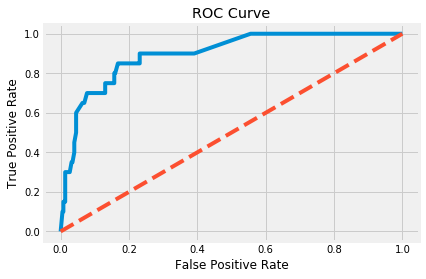

In [67]:
features = ['simult_bids', 'avg_bids_per_auction', 'merchandise_auto parts_y',
       'merchandise_books and music_y', 'merchandise_clothing_y',
       'merchandise_computers_y', 'merchandise_furniture_y',
       'merchandise_home goods_y', 'merchandise_jewelry_y', 'merchandise_mobile_y',
       'merchandise_office equipment_y', 'merchandise_sporting goods_y', 
        'time_since_previous_bid', 'time_since_last_auction_bid']
target = ["outcome"]
dt = .20
split_and_repeated_strat_cross_val(df_bidders, gb, features, target, dt)

# Conclusion:

After engineering various features, testing out different model types, and decision thresholds, I ended up with a gradient boosting algorithm that successfully detected robots with an F1 score of .68. Of course, as soon as we deploy this model, bots will certainly adapt to try to evade detection, so we'll need to continually adapt with them if we want to rid auction sites of these pesky bumbling, bags of bolts forever.